In [1]:
from CNN_utils import *
import pandas as pd
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder

tf.config.run_functions_eagerly(True)  # Force eager execution

from tensorflow.keras.utils import to_categorical
import numpy as np


2025-04-24 14:59:31.564651: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 14:59:31.567153: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 14:59:31.574020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 14:59:31.594700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745499571.631277  767804 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745499571.64

### 1. + 2. Dataset import and split


Duration of each sample:  0.9752380952380952 s
Train set
Number of elements in each class:  120
Number of sounds in dataset:  480


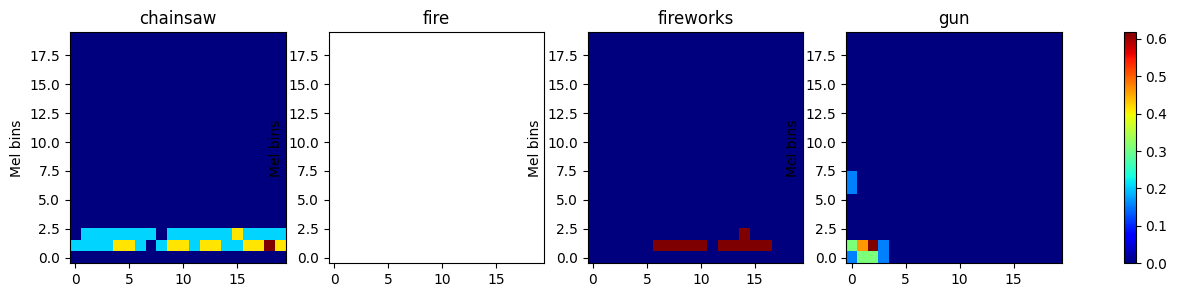

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

Test set
Number of elements in each class:  40
Number of sounds in dataset:  160


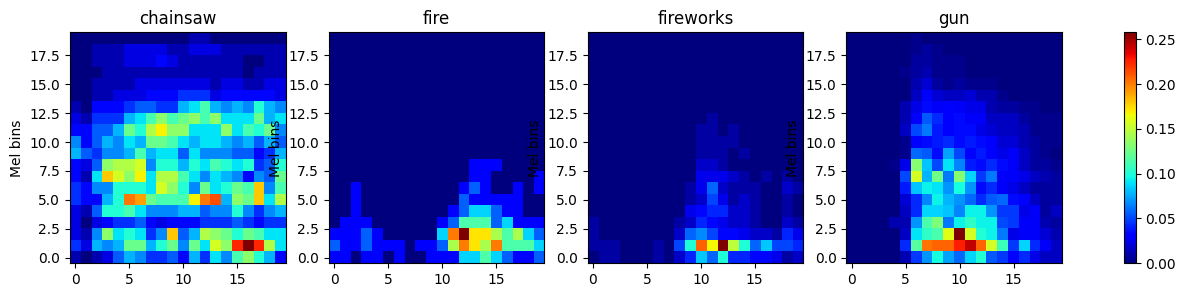

In [9]:
#Physical HP
#------------------------------------
Nft = 512
samples_per_melvec = Nft
n_melvec = 20
melvec_height = 20
window_type = "hamming" #hamming, hanning, blackman, rectangular, triangular
sr = 10500
flag_8bit = True #True
bit_sensitivity = 3 #0.1

#Visualisation
img_idx = 101
test_img_idx = 1

#HUGE CHANGE: trainset and testset are now obsolete:
#The train set is now totalset, without the background noise
#filter_str: only keeps the files that contain the filter_str
#The "physical_bg" noise now corresponds to the youtube sounds
#The test set is now the background noise

#TODO: When youtube sounds proved to be usedfull, modify Dataset class 
#so that they are taking into account in the time shift and add_bg
#------------------------------------

#1. Import classical  - #2. Train-test split
#--------------------------------
duration = n_melvec * Nft / sr 
print("Duration of each sample: ", duration, "s")


print("Train set")
#Does not take the background noise and youtube sounds into account
myds, dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/trainset_with_new/", filter_str=None,
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr, flag_8bit = flag_8bit, bit_sensitivity=bit_sensitivity,
    normalize=True, shift_pct=0, verbose=True, img_idx = img_idx, play_sound=True)

print("Test set")
myds_test, dataset_test, _ = get_dataset(path="../datasets/sounds/recorded_sounds/testset_with_new/", filter_str=None, #"_background_",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr,  flag_8bit = flag_8bit, bit_sensitivity=bit_sensitivity,
    normalize=True, shift_pct=0, verbose=True, img_idx = test_img_idx, play_sound=False)




Dataset Augmentations
pickle_name:  ../datasets/melvecs/HP_tuning/melvecs_int8s3_512_512_20_20_hamming_10500

TRAIN SET
Previously computed dataset successfully loaded!
Shape of feature matrix: (480, 400)
Number of labels: 480
Plotting index: 101 (Aug: 0, Class: chainsaw, Img: 101)
Plotting index: 221 (Aug: 0, Class: fire, Img: 101)
Plotting index: 341 (Aug: 0, Class: fireworks, Img: 101)
Plotting index: 461 (Aug: 0, Class: gun, Img: 101)
Skipping aug_idx 1, class_idx 0, img_idx 101: Index out of bounds.
Skipping aug_idx 1, class_idx 1, img_idx 101: Index out of bounds.
Skipping aug_idx 1, class_idx 2, img_idx 101: Index out of bounds.
Skipping aug_idx 1, class_idx 3, img_idx 101: Index out of bounds.


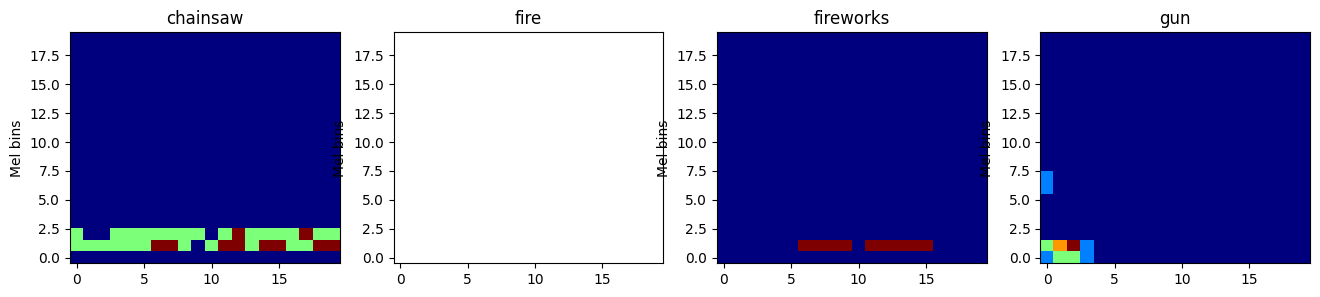

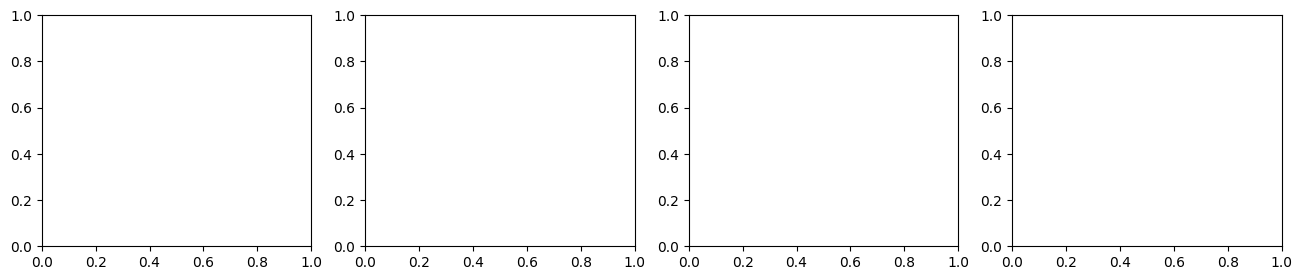

TEST SET
pickle_name_test:  ../datasets/melvecs/HP_tuning/melvecs_test_int8s3_512_512_20_20_hamming_10500
Previously computed dataset successfully loaded!
X_test shape:  (160, 400)
Removed 17 invalid samples!
X_train shape after removing invalid samples: (463, 400)


In [11]:
#3. Dataset augmentations
#----------------------------
#physical_bg is now physical_bg, name not changed inside the files

img_idx = 101
#CAREFUL: always respect the order
#augmentations = ["time_shift", "add_bg", "physical_bg"]
#augmentations = ["physical_bg"] #Physical bg is now youtube - TODO: correct the dataset code
augmentations = []
shift_nb = 10                  if "time_shift" in augmentations else 0
bg_amplitude_limit = [0.1, 0.316] if "add_bg" in augmentations else []      #0.1: 20dB, 0.316: 5dB
physical_aug = ("physical_bg" in augmentations)

plot_indexes = [0,1]
load_matrix = True

print("\nDataset Augmentations")
if "add_bg" in augmentations:
    bg_dataset = Dataset(folder="../datasets/sounds/recorded_sounds/background/", filter_str=None)
else :
    bg_dataset = None

if "physical_bg" in augmentations:
    my_phy_ds, phy_bg_dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/totalset/", filter_str="youtube",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr,  flag_8bit = flag_8bit, bit_sensitivity=bit_sensitivity,
    normalize=True, shift_pct=0, verbose=False, img_idx = img_idx, play_sound=False)
else :
    my_phy_ds = None
    phy_bg_dataset = None


pickle_name = get_picklename( flag_8bit, bit_sensitivity,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations,shift_nb,bg_amplitude_limit,physical_aug,
    prefix="../datasets/melvecs/HP_tuning/",
    purpose = "melvecs" # "model"
)
#pickle_name+="_1_"
print("pickle_name: ", pickle_name)

#---------------------------------

#Visualisation purposes
verbose = True
play_sound = True
print()
print("TRAIN SET")
X_train, y_train = augment_dataset(myds, dataset, classnames, augmentations, melvec_height=melvec_height,
                    shift_nb = shift_nb, #numbers of shifts done
                    bg_dataset = bg_dataset, bg_amplitude_limit=bg_amplitude_limit, #dataset used for background noise, background amplitudes
                    physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                    verbose=verbose, img_idx=img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
                    load_matrix=load_matrix, pickle_name=pickle_name) #load and save parameters

"""
TODO: ADD SHIFTS TO THE TEST SET
"""
print("TEST SET")
plot_indexes = [0]
verbose = False
play_sound = False

augmentations_test = []
#augmentations_test = ["time_shift"] 
nb_shift_test = 0

pickle_name_test = get_picklename(
    flag_8bit, bit_sensitivity,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations_test,nb_shift_test,bg_amplitude_limit,physical_aug,
    prefix="../datasets/melvecs/HP_tuning/",
    purpose = "melvecs_test" # "model"
)
#pickle_name_test+="_1_"
print("pickle_name_test: ", pickle_name_test)
load_matrix_test = True


X_test, y_test = augment_dataset(myds_test, dataset_test, classnames, augmentations = augmentations_test
                                 , melvec_height=melvec_height,
                                 
                shift_nb = nb_shift_test, #numbers of shifts done
                bg_dataset = None, bg_amplitude_limit=[], #dataset used for background noise, background amplitudes
                physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                verbose=verbose, img_idx=img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
               load_matrix=load_matrix_test, pickle_name=pickle_name_test) #load and save parameters

#Print shape of the test set
print("X_test shape: ", X_test.shape)

# Transform the labels to integers and save mapping
label_to_id = {label: i for i, label in enumerate(classnames)}
id_to_label = {i: label for label, i in label_to_id.items()}
y_train = np.array([label_to_id[label] for label in y_train])
y_test = np.array([label_to_id[label] for label in y_test])


#Shuffle X_train and y_train
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]



# Identify invalid samples (all zeros or NaNs)
invalid_mask = np.any(np.isnan(X_train), axis=tuple(range(1, X_train.ndim))) | \
               np.all(X_train == 0, axis=tuple(range(1, X_train.ndim)))

# Invert the mask to get valid entries
valid_mask = ~invalid_mask

# Filter X_train and y_train
X_train = X_train[valid_mask]
y_train = y_train[valid_mask]

print(f"Removed {np.sum(invalid_mask)} invalid samples!")
print(f"X_train shape after removing invalid samples: {X_train.shape}")



### 5. Modelling

In [12]:

#CNN architecture
#----------------------------------------------
#Tuner
epochs = 10
epochs_tuner = 8
validation_split = 0.3
patience = 10


#A. HyperResNet
hyperResNet = HyperResNet(input_shape=X_train.shape[1:], classes=4)

#B. HyperEfficientNet
hyperEfficientNet = HyperEfficientNet(input_shape=X_train.shape[1:], classes=4)

#C. HyperXception
hyperXception = HyperXception(input_shape=X_train.shape[1:], classes=4)

#D. Self-made 1
def self_made_builder_factory(input_shape):
    #Enable to pass input_shape to the function
    def self_made_builder(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape = input_shape))
        model.add(tf.keras.layers.Flatten())

        hp_activation = hp.Choice('activation', values=['relu']) #'tanh', 'sigmoid'])

        for i in range(hp.Int("num_layers", 1,1)):
            model.add(
                tf.keras.layers.Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"layer_{i}", min_value=256, max_value=256, step=1),
                    activation=hp_activation,
                )
            )
            ## Add dropout after each dense layer
            #model.add(
            #    tf.keras.layers.Dropout(
            #        rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)
            #    )
            #)
        #hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=512, step=32)
        #hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=512, step=32)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 

        #model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
        #model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
        model.add(tf.keras.layers.Dense(4, activation='softmax'))

        opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model
    return self_made_builder

#label_encoder = LabelEncoder()
#y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers

def create_tuner(hypermodel):
    return kt.Hyperband(hypermodel,
                    objective='val_accuracy',
                    max_epochs=epochs_tuner,
                    factor=3,
                    directory='hp_dir',
                    project_name='basic_ref_model',
                    overwrite= False)
'''
basic_ref_model
Hyperparameters:
activation: relu
num_layers: 1
layer_0: 256
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7013888955116272
Kfold: 82
Test: 58
'''

#(A: HyperResNet, B: HyperEfficientNet, C: HyperXception, D: self_made_builder)
input_shape = X_train.shape[1:]
builder = self_made_builder_factory(input_shape)
tuner = create_tuner(builder)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

tuner.search(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])
tuner.results_summary()

Reloading Tuner from hp_dir/basic_ref_model/tuner0.json
Results summary
Results in hp_dir/basic_ref_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0002 summary
Hyperparameters:
activation: relu
num_layers: 1
layer_0: 256
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7291666865348816

Trial 0000 summary
Hyperparameters:
activation: relu
num_layers: 1
layer_0: 256
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5763888955116272

Trial 0001 summary
Hyperparameters:
activation: relu
num_layers: 1
layer_0: 256
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3472222089767456


2025-04-24 15:12:12.429269: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### 6. Training

In [13]:
#5. Final model
validation_split = 0.3
final_epochs = 50
final_patience = 10
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=final_patience, restore_best_weights=True)


model_name = get_picklename(
    flag_8bit, bit_sensitivity,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations,shift_nb,
    bg_amplitude_limit,physical_aug,
    prefix="../datasets/models/",
    purpose = "model"
)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Best hyperparameters: ", best_hps.values)

#Temporary model to find the best number of epochs - avoid overfitting
temp_model = tuner.hypermodel.build(best_hps)
history = temp_model.fit(X_train, y_train, epochs=final_epochs, validation_split=validation_split, callbacks=[stop_early])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best hyperparameters:  {'activation': 'relu', 'num_layers': 1, 'layer_0': 256, 'learning_rate': 0.01, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/50


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3660 - loss: 1.2588 - val_accuracy: 0.6043 - val_loss: 1.0704
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6317 - loss: 0.9338 - val_accuracy: 0.6835 - val_loss: 0.9060
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7821 - loss: 0.6593 - val_accuracy: 0.7266 - val_loss: 0.8891
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8342 - loss: 0.5247 - val_accuracy: 0.7050 - val_loss: 0.8853
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8600 - loss: 0.4262 - val_accuracy: 0.7194 - val_loss: 0.8644
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8904 - loss: 0.3317 - val_accuracy: 0.7338 - val_loss: 0.8398
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9166 - loss: 0.2471 - val_accuracy: 0.7122 - val_loss: 0.8834
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9371 - loss: 0.2011 - val_accuracy: 0.7194 - val_loss: 0.

### 8. Final model evaluation

Epoch 1/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3840 - loss: 1.2849 - val_accuracy: 0.5899 - val_loss: 1.0902
Epoch 2/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6316 - loss: 0.9211 - val_accuracy: 0.6619 - val_loss: 0.9290
Epoch 3/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7636 - loss: 0.7052 - val_accuracy: 0.6475 - val_loss: 0.9267
Epoch 4/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8384 - loss: 0.4777 - val_accuracy: 0.7410 - val_loss: 0.8859
Epoch 5/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8708 - loss: 0.3908 - val_accuracy: 0.7410 - val_loss: 0.8615
Epoch 6/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8921 - loss: 0.3144 - val_accuracy: 0.6691 - val_loss: 0.9879
K-fold cross-validation

--- Fold 1/5 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Fold 2/5 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Fold 3/5 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Fold 4/5 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/s

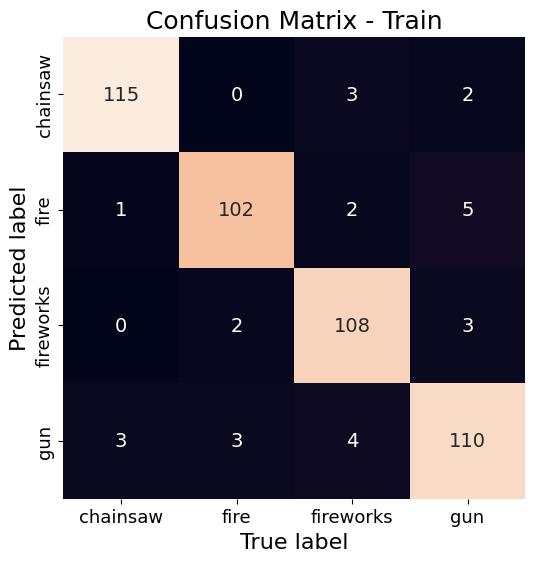

Confusion Matrix (Test):


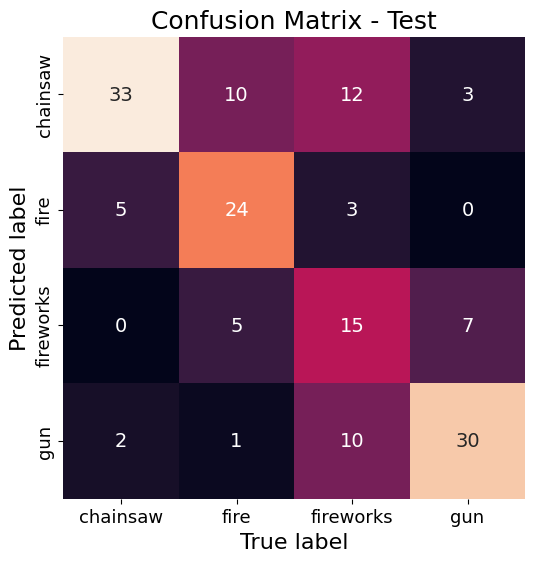


Classification Report:
Train: 
              precision    recall  f1-score   support

    chainsaw       0.96      0.97      0.96       119
        fire       0.93      0.95      0.94       107
   fireworks       0.96      0.92      0.94       117
         gun       0.92      0.92      0.92       120

    accuracy                           0.94       463
   macro avg       0.94      0.94      0.94       463
weighted avg       0.94      0.94      0.94       463

Test: 
              precision    recall  f1-score   support

    chainsaw       0.57      0.82      0.67        40
        fire       0.75      0.60      0.67        40
   fireworks       0.56      0.38      0.45        40
         gun       0.70      0.75      0.72        40

    accuracy                           0.64       160
   macro avg       0.64      0.64      0.63       160
weighted avg       0.64      0.64      0.63       160

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6

In [15]:
#Final results
#------------------------------
#Remove tensorflow warnings
tf.data.experimental.enable_debug_mode()

#Train the model with the best hyperparameters and best epoch
hypermodel = tuner.hypermodel.build(best_hps)
hp_learning_rate = best_hps.get('learning_rate')
opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
hypermodel.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=validation_split) #validation_split=validation_split)
k = 5
epochs_kfold = 20
save_model = False

#Clone the model for k-fold
kfold_model = tf.keras.models.clone_model(hypermodel)
#Get the best tuning rate from the best hyperparameters
hp_learning_rate = best_hps.get('learning_rate')
opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
kfold_model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


 # Make sure to recompile
# Train of the model & evaluation -  K-Fold cross-validation
kfold_acc, kfold_recall, kfold_f1 = perform_kfold(kfold_model, X_train, y_train, k=k, epochs=epochs_kfold)




#Train- Test evaluation
train_confmat, train_report, test_accuracy, test_confmat, test_report= evaluate_model(hypermodel, 
                        X_train, y_train, classnames, X_test, y_test,show_confusion=True)


if (X_test is not None):
    predictions = hypermodel.predict(X_test)
    eval_result = hypermodel.evaluate(X_test, y_test)
    print("[test loss, test accuracy]:", eval_result)

if save_model:
    model_name = get_picklename(
        flag_8bit, bit_sensitivity,        
        Nft,
        samples_per_melvec,
        n_melvec,
        melvec_height,
        window_type,
        sr,
        augmentations,
        shift_nb,
        bg_amplitude_limit,
        physical_aug,
        prefix="../datasets/models/",
        purpose = "model"
    )
    model_name += "tuesday22_04_no_aug" 
    #Add _train_{kfold_acc}_test_{test_accuracy} to the name
    #model_name += "_train_{:.0f}_test_{:.0f}".format(np.mean(fold_acc_acc*100), test_accuracy*100)

    #Check if the model already exists
    if os.path.exists(model_name + ".h5"):
        print("Model already exists!!")
        model_name = model_name + "_new"
    print("Saving model to: ", model_name)
    hypermodel.save(model_name + ".h5")


In [7]:
'''
def evaluate_tuner(epochs, validation_split, patience, epochs_tuner,y_train):

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers


    input_shape = X_train.shape[1:]
    builder = self_made_builder_factory(input_shape)
    tuner = create_tuner(builder)

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    tuner.search(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))

    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=validation_split)


    k = 5
    epochs_kfold = 10
    save_model = False

    # Train evaluation -  K-Fold cross-validation
    kfold_acc, kfold_recall, kfold_f1 = perform_kfold(hypermodel, X_train, y_train, k=k, epochs=epochs_kfold)


    # Test evaluation
    train_confmat, train_report, test_accuracy, test_confmat, test_report = evaluate_model(hypermodel, 
                            X_train, y_train, classnames, X_test, y_test,show_confusion=False)
    
    return kfold_acc, test_accuracy


epochs_tab = [1,2,3,4,5,6,7,8,9,10]
#epochs_tuner_tab = [1,2,3,4,5]
epochs_tuner_tab = [3]
validation_split = 0.2
patience = 5

kfold_acc_res = []
test_accuracy_res = []

for epochs in epochs_tab:
    for epochs_tuner in epochs_tuner_tab:
        print("EPOCHS: ", epochs)
        kfold_acc, test_accuracy = evaluate_tuner(epochs, validation_split, patience, epochs_tuner, y_train, )
        print(f"Epochs: {epochs}, Tuner Epochs: {epochs_tuner}, K-Fold Accuracy: {kfold_acc}, Test Accuracy: {test_accuracy}")
        kfold_acc_res.append(kfold_acc)
        test_accuracy_res.append(test_accuracy)


name = "tuner_tab_3"

#Save reult for epochs_tab
df = pd.DataFrame({
    'epochs': epochs_tab,
    'kfold_acc': kfold_acc_res,
    'test_accuracy': test_accuracy_res
})
df.to_csv(f"../datasets/GSresults/GS_results_{name}.csv", index=False)
plot_results(epochs_tab, kfold_acc_res = kfold_acc_res, test_accuracy_res = test_accuracy_res, name= name, xlabel="# epochs", title="performances", prefix="../datasets/GSresults/")
"""

#Save reult for epochs_tuner_tab
df = pd.DataFrame({
    'epochs_tuner': epochs_tuner_tab,
    'kfold_acc': kfold_acc_res,
    'test_accuracy': test_accuracy_res
})

df.to_csv(f"../datasets/GSresults/GS_results_{name}.csv", index=False)
plot_results(epochs_tab, kfold_acc_res = kfold_acc_res, test_accuracy_res = test_accuracy_res, name= name, xlabel="# epochs", title="performances", prefix="../datasets/GSresults/")
"""
'''

'\ndef evaluate_tuner(epochs, validation_split, patience, epochs_tuner,y_train):\n\n    label_encoder = LabelEncoder()\n    y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers\n\n\n    input_shape = X_train.shape[1:]\n    builder = self_made_builder_factory(input_shape)\n    tuner = create_tuner(builder)\n\n    stop_early = tf.keras.callbacks.EarlyStopping(monitor=\'val_loss\', patience=patience)\n\n    tuner.search(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])\n\n    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]\n\n    model = tuner.hypermodel.build(best_hps)\n    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])\n\n    val_acc_per_epoch = history.history[\'val_accuracy\']\n    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1\n    print(\'Best epoch: %d\' % (best_epoch,))\n\n    hypermodel = tuner.hypermodel.build(best_hps)\